# Plot Stats comparisons for manual tuning runs

In [1]:
using Plots
using Base.Filesystem: pwd, dirname, joinpath
using Base.Iterators: product
using Formatting
using Printf


In [2]:
using Pandas: read_pickle

In [195]:
PROJECT_ROOT = dirname(pwd())

"/work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks"

In [224]:
# var_name = "tphystnd-691.39";
var_name = "tphystnd-820.86";

## Get SingleNN and CausalSingleNN stats

In [225]:
path_stats_single_nn = joinpath(PROJECT_ROOT, "output_castle/eval_nando/single_nn/plots_offline_evaluation/stats")
path_stats_causal_single_nn = joinpath(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/plots_offline_evaluation/stats");

In [226]:
i_time = "range"
n_time = "1440";

In [227]:
stats_file = "$(i_time)-$(n_time).p/hor_stats.p"

"range-1440.p/hor_stats.p"

In [228]:
stats_single_nn = read_pickle(joinpath(path_stats_single_nn, stats_file));

In [229]:
stats_casual_single_nn = read_pickle(joinpath(path_stats_causal_single_nn, stats_file));

In [230]:
stats_single_nn = stats_single_nn[var_name]
stats_casual_single_nn = stats_casual_single_nn[var_name]

Dict{Any, Any} with 5 entries:
  "hor_tsqmean" => 8.37872e-9
  "hor_mse"     => 4.21962e-9
  "hor_tmean"   => -2.71953e-6
  "hor_r2"      => 0.495943
  "hor_tvar"    => 8.37132e-9

## Get trained CASTLE model stats

In [231]:
path_stats_castle_trained = joinpath(PROJECT_ROOT, "output_castle/training_28_custom_mirrored_functional/plots_offline_evaluation/run_1/stats")

"/work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/training_28_custom_mirrored_functional/plots_offline_evaluation/run_1/stats"

In [232]:
stats_file = "$(i_time)-$(n_time)/hor_stats.p"

"range-1440/hor_stats.p"

In [233]:
stats_castel_trained = read_pickle(joinpath(path_stats_castle_trained, stats_file))
stats_castel_trained = stats_castel_trained[var_name]


Dict{Any, Any} with 5 entries:
  "hor_tsqmean" => 8.37872e-9
  "hor_mse"     => 5.58679e-9
  "hor_tmean"   => -2.71953e-6
  "hor_r2"      => 0.332628
  "hor_tvar"    => 8.37132e-9

## Get manual tuning stats

In [253]:
base_dir = joinpath(PROJECT_ROOT, "output_castle", "manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he") #"manual_tuning_tphystnd_691.39_v3-test2"
tuning_models = ["castle_adapted_big_notears"] 
                #"castle_adapted_small_notears", "castle_adapted_small_dagma", "castle_adapted_big_dagma"]

lambda_prediction =[1, 5,  10, 100, 1000] # [1, 2, 4, 8, 10]
lambda_sparsity = [1.0]; # [0.1, 0.5, 1.0];


In [254]:
function read_stats(tuning_model)  
    stats_dict = Dict{Tuple{Int64, Float64}, Dict}()
    
    for (p, s) in product(lambda_prediction, lambda_sparsity)
        tuning_dir = "lambda_pred_$(p)-lambda_sparsity_$(s)"
        file_name = "$(i_time)_$(n_time)_$(var_name).p"

        stats_file = joinpath(base_dir, "evaluation", tuning_model, tuning_dir, "stats", file_name)
        
        stats_dict[(p, s)] = read_pickle(stats_file)
    end
    return stats_dict
end

read_stats (generic function with 1 method)

In [255]:
manual_tuning_dicts = Dict()
for tuning_model in tuning_models
    manual_tuning_dicts[tuning_model] = read_stats(tuning_model)
end

In [256]:
manual_tuning_dicts

Dict{Any, Any} with 1 entry:
  "castle_adapted_big_notears" => Dict{Tuple{Int64, Float64}, Dict}((1000, 1.0)…

## Plot histograms

In [257]:
using StatsBase
using LaTeXStrings
using Plots.PlotMeasures

In [258]:
palette = cgrad(:thermal, 5, categorical = true, rev = true)


In [259]:
plot_output_dir = joinpath(base_dir, "evaluation", "stats_plots")
mkpath(plot_output_dir);

In [260]:
function plot_stats_histogram(tuning_model, statistic, save_fig=false)
    file_name = "comparison_$(tuning_model)_$(statistic).png"
    
    x = [stats_single_nn["hor_" * statistic], stats_casual_single_nn["hor_" * statistic], 
        stats_castel_trained["hor_" * statistic]]
    for (p, s) in product(lambda_prediction, lambda_sparsity)
        push!(x, manual_tuning_dicts[tuning_model][(p, s)]["hor_" * statistic])
    end

    x_ticks = ["SingleNN", "CausalSingleNN", L"CASTLE $\lambda_p = 1, \lambda_s = 1$"]
    for (p, s) in product(lambda_prediction, lambda_sparsity)
        push!(x_ticks, L"\lambda_p = %$p, \lambda_s = %$s")
    end

    palette = cgrad(:thermal, 5, categorical = true, rev = true)

    data = Dict(x_ticks .=> x)

    b = bar((x -> data[x]).(x_ticks), xrotation=75, 
            color=[palette[min(i, 4)] for i in range(1,length(x))],
            label="", 
            size=(800,600), 
            xticks=(1:length(x_ticks), x_ticks),
            xtickfont=font(10, "Courier"), 
            bottom_margin=12mm, 
            left_margin=10mm, 
            top_margin=10mm,
            right_margin=10mm,
            dpi=800)
    
    # print((x -> data[x]).(x_ticks))
   
    # text("mytext", :red, :right, 3))
    # annotate!(df.group, df.value, df.value, :bottom)

    if statistic == "r2"
        ylims!(minimum(x)-0.1, 1.1)
        hline!([1], color=palette[5], label="")
        hline!([0], color=:black, label="")
        
        annotation_text = map( l-> @sprintf("%.4f", l), x)
    elseif statistic == "mse"
        ylims!(0, maximum(x))
        hline!([0], color=:black, label="")
        
        annotation_text = map( l-> @sprintf("%4.e", l), x)
    end

    annotate!(1:length(x_ticks), x, [text(i, :bottom, 9) for i in annotation_text], :bottom)

    if tuning_model == "castle_adapted_small_notears"
        title_model = "CASTLEAdapted with NOTEARS (4 x 128)"
    elseif tuning_model == "castle_adapted_big_notears"
        title_model = "CASTLEAdapted with NOTEARS (9 x 256)"
    elseif tuning_model == "castle_adapted_small_dagma"
        title_model = "CASTLEAdapted with DAGMA (4 x 128)"
    elseif tuning_model == "castle_adapted_big_dagma"
        title_model = "CASTLEAdapted with DAGMA (9 x 256)"
    end
    
    if statistic == "r2"
        stats_label = "R2"
    elseif statistic == "mse"
        stats_label = "MSE"
    end        
    
    title!("\n$(title_model) for Variable $(var_name)\n$(stats_label) Scores for SingleNN, CausalSingleNN and tuning runs", titlefont = font(13,"Helvetica Bold"),)
    ylabel!("$(stats_label) Score")
    
    display(b)
    if save_fig
        Plots.savefig(b, joinpath(plot_output_dir, file_name))
    end
end

plot_stats_histogram (generic function with 2 methods)

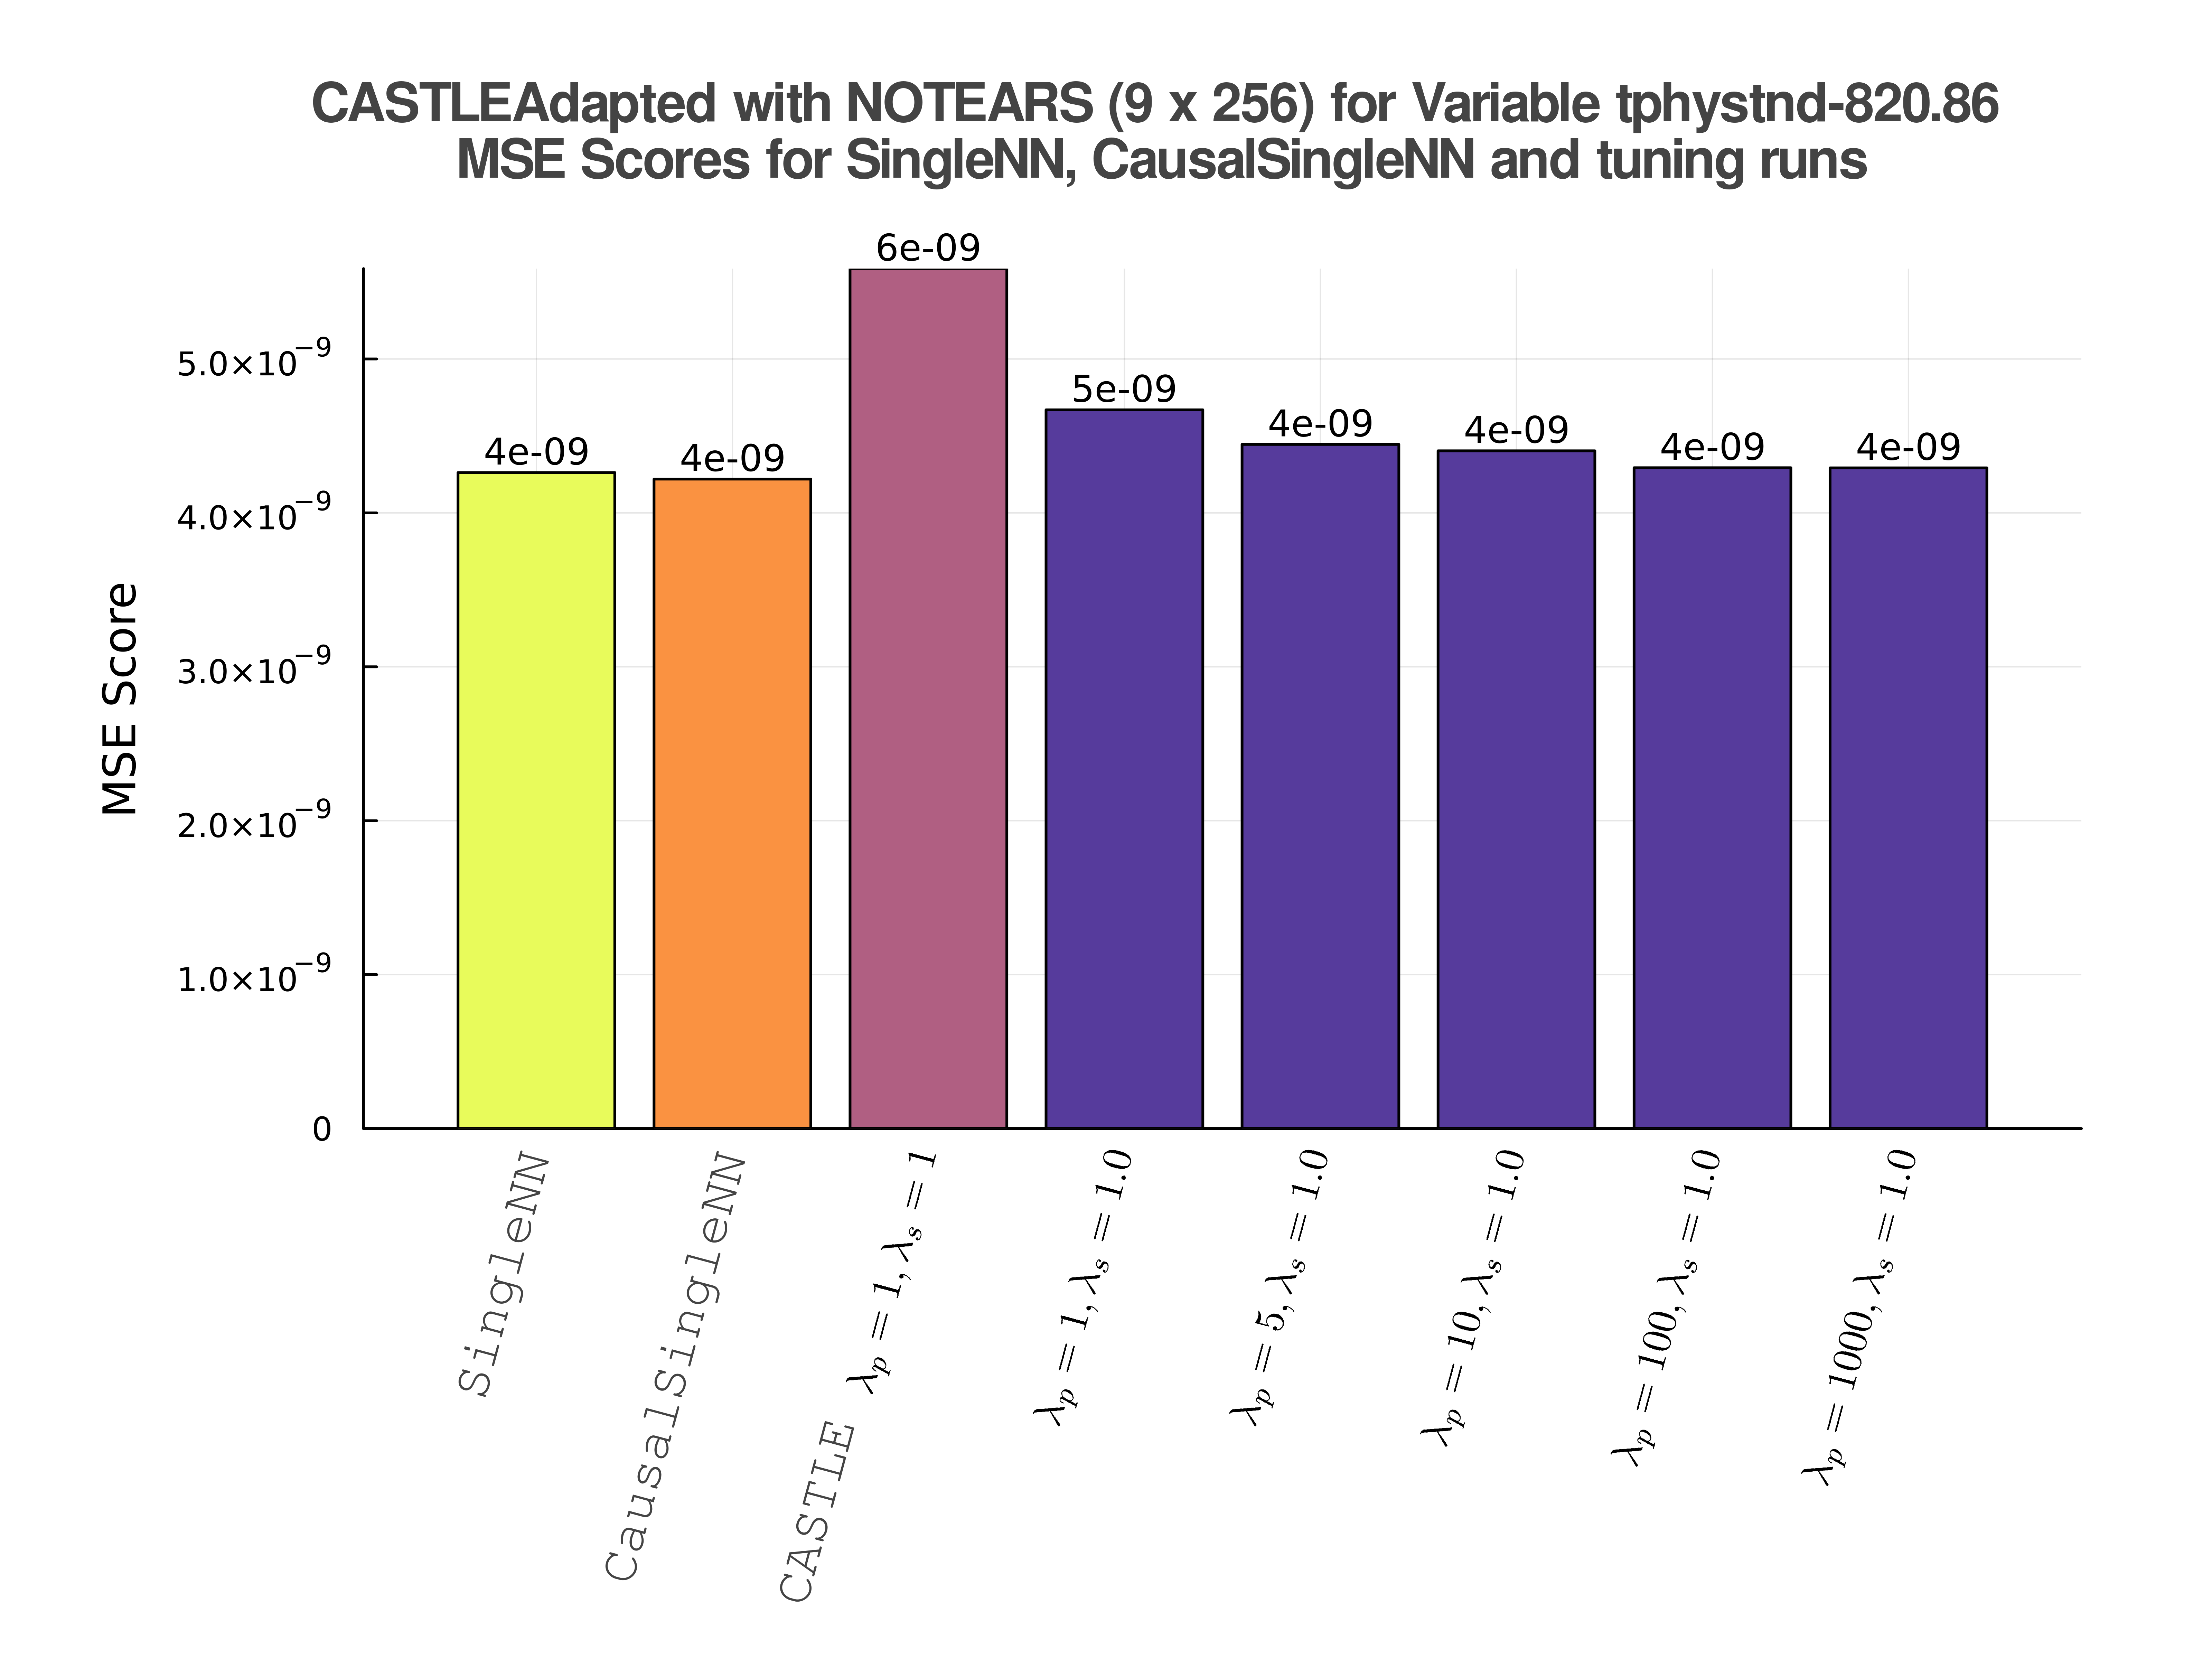

"/work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v5-transposed_l1_entry_scaled_init_he/evaluation/stats_plots/comparison_castle_adapted_big_notears_mse.png"

In [262]:
plot_stats_histogram(tuning_models[1], "mse", true)


In [ ]:
plot_stats_histogram(tuning_models[2], "mse", true)

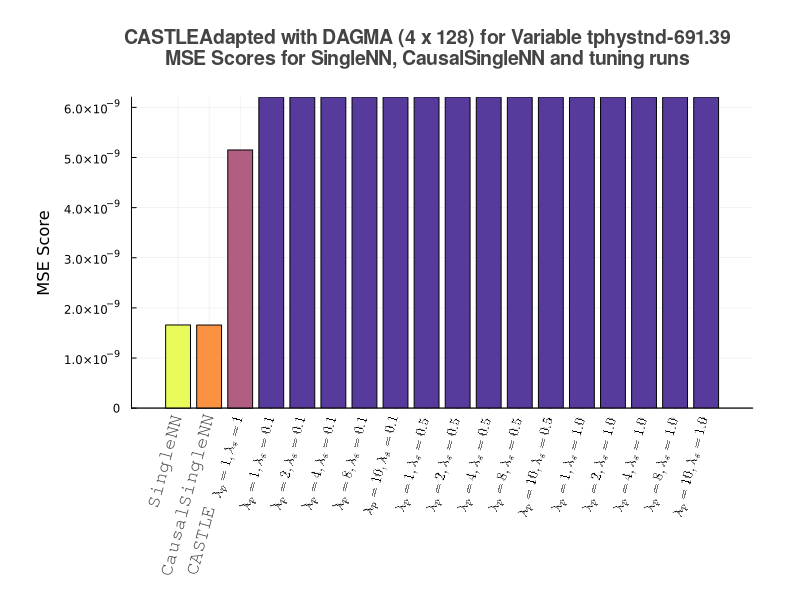

"/work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v3/evaluation/stats_plots/comparison_castle_adapted_small_dagma_mse.png"

In [61]:
plot_stats_histogram(tuning_models[3], "mse", true)


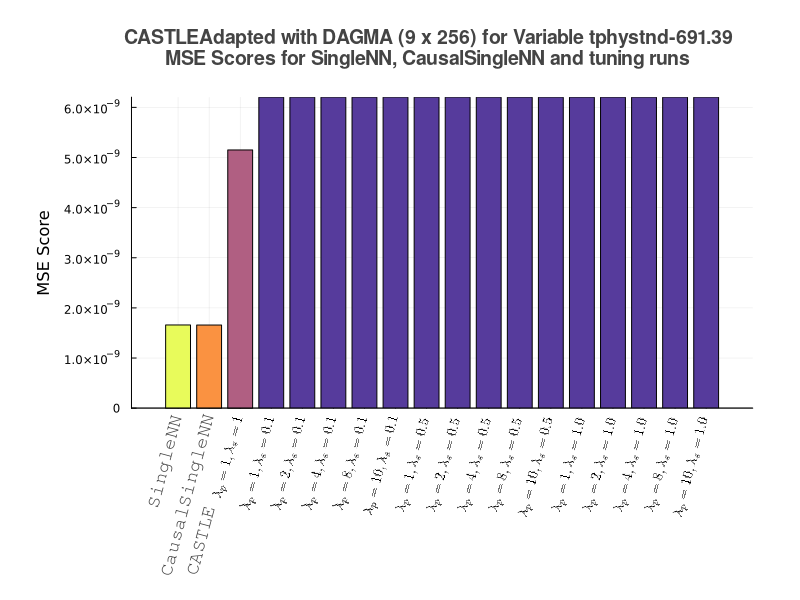

"/work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_691.39_v3/evaluation/stats_plots/comparison_castle_adapted_big_dagma_mse.png"

In [62]:
plot_stats_histogram(tuning_models[4], "mse", true)


## Best values

In [173]:
function print_stats(tuning_model, statistic)
    
    if statistic == "r2"
        println("\nR2 statistics: \n")
    elseif statistic == "mse"
        println("\nMSE statistics: \n")
    end 
    
    printfmt("{1:<50s}{2:.12f}\n", "SingleNN:", stats_single_nn["hor_" * statistic])
    printfmt("{1:<50s}{2:.12f}\n", "CausalSingleNN:", stats_casual_single_nn["hor_" * statistic])
    printfmt("{1:<50s}{2:.12f}\n", "CASTLE lambda_p = 1, lambda_s = 1:", stats_castel_trained["hor_" * statistic])  
    
    x = Dict{Tuple{Int64, Float64}, Float64}()
    for (p, s) in product(lambda_prediction, lambda_sparsity)
        x[(p,s)] = manual_tuning_dicts[tuning_model][(p, s)]["hor_" * statistic]
    end
    
    for (p, s) in product(lambda_prediction, lambda_sparsity)
        printfmt("{1:<50s}{2:.12f}\n", "CASTLE tuning lambda_p = $p, lambda_s = $s:", x[(p,s)])
    end
    
    
    if statistic == "r2"
        max_keys = collect(keys(x))[argmax(collect(values(x)))]
        max_value = x[max_keys]
        printfmt("\n{1:<50s}{2:.12f}\n{3: >65s}\n", "Maximum R2 tuning value:", max_value, "With lambda_prediction = $(max_keys[1]), lambda_sparsity = $(max_keys[2])")
    elseif statistic == "mse"
        min_keys = collect(keys(x))[argmin(collect(values(x)))]
        min_value = x[min_keys]
        printfmt("\n{1:<50s}{2:.12f}\n{3: >65s}\n", "Minimum MSE tuning value:", min_value, "With lambda_prediction = $(min_keys[1]), lambda_sparsity = $(min_keys[2])")
    end
end     

print_stats (generic function with 1 method)

In [174]:
print_stats(tuning_models[1], "r2")


R2 statistics: 

SingleNN:                                         0.732535547135
CausalSingleNN:                                   0.732749783619
CASTLE lambda_p = 1, lambda_s = 1:                0.169610040297
CASTLE tuning lambda_p = 1, lambda_s = 1.0:       0.686719280445
CASTLE tuning lambda_p = 10, lambda_s = 1.0:      0.706949975853
CASTLE tuning lambda_p = 100, lambda_s = 1.0:     0.718435438357
CASTLE tuning lambda_p = 1000, lambda_s = 1.0:    0.723754134303
CASTLE tuning lambda_p = 10000, lambda_s = 1.0:   0.724837521732

Maximum R2 tuning value:                          0.724837521732
            With lambda_prediction = 10000, lambda_sparsity = 1.0


In [175]:
print_stats(tuning_models[1], "mse")


MSE statistics: 

SingleNN:                                         0.000000001659
CausalSingleNN:                                   0.000000001658
CASTLE lambda_p = 1, lambda_s = 1:                0.000000005150
CASTLE tuning lambda_p = 1, lambda_s = 1.0:       0.000000001943
CASTLE tuning lambda_p = 10, lambda_s = 1.0:      0.000000001818
CASTLE tuning lambda_p = 100, lambda_s = 1.0:     0.000000001746
CASTLE tuning lambda_p = 1000, lambda_s = 1.0:    0.000000001713
CASTLE tuning lambda_p = 10000, lambda_s = 1.0:   0.000000001707

Minimum MSE tuning value:                         0.000000001707
            With lambda_prediction = 10000, lambda_sparsity = 1.0


# DAGMA Matrix Domain Check

In [52]:
using LinearAlgebra
using Distributions
using Random

In [45]:
w_init = rand(Uniform(-0.01,0.01), 10, 10)

10×10 Matrix{Float64}:
 -0.00334435    0.00611058   0.00816083   …  -0.00924793  -0.000206418
 -0.00421972   -0.00265254  -0.00787603       0.00791923   0.00341314
  0.00456824    0.00697492   0.00736918       0.00367616   0.00722528
 -0.00807782   -0.00282315   0.00892602       0.00203095  -0.00900152
 -0.00108842   -0.00215186   0.0010911       -0.00483784  -0.000548109
  0.000824388  -0.00673776   0.00146133   …  -0.00836516  -0.0013327
  0.00380449    0.00749026  -0.000433467     -0.00742275   0.00496146
  0.00882637   -0.00801158   0.00792959       0.00332695  -0.0068909
  0.00605563    0.00760434   0.00287966       0.00440348  -0.00849732
 -0.00519277    0.00891426   0.00897887      -0.00981689   0.00970416

In [48]:
function spectral_radius(m)
    return maximum(broadcast(abs, eigvals(m * m)))
end;

In [49]:
spectral_radius(w_init)

0.0004754688272533003